In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import beta, gamma, norm
from cvxopt import matrix, solvers
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')
solvers.options['reltol'] = 1e-5
solvers.options['abstol'] = 1e-6
solvers.options['feastol'] = 1e-6
solvers.options['show_progress'] = False

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setup

In [3]:
from google.colab import drive
drive.mount('/drive')

#read in the field dims
field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/field_dims.csv')

Mounted at /drive


In [4]:
#define run values. Same ones I used in sloan paper
count_runs = pd.DataFrame({'balls': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

In [6]:
def get_utility(grid, balls = 0, strikes = 0):
    #grid is the pitch grid defined later on in the notebook.
    count_pre = count_runs.loc[(count_runs.balls == balls) & (count_runs.strikes == strikes)]

    #get the value of a called ball
    val0 = count_pre.val_ball.values[0]

    #get the value of a called or swinging strike
    val12 = count_pre.val_strike.values[0]

    #value of a foul ball
    if strikes == 2:
        #no change
        val3 = 0
    else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0]

    #value of ball in play out
    val4 = count_pre.val_out.values[0]
    #single
    val5 = count_pre.val_single.values[0]
    #double
    val6 = count_pre.val_double.values[0]
    #triple
    val7 = count_pre.val_triple.values[0]
    #hr
    val8 = count_pre.val_hr.values[0]

    no_swing = grid.o0.values + grid.o1.values
    swing = grid[['o2','o3','xbip']].values.sum(axis = 1)
    take_utility = (grid.o0.values / no_swing) * val0 + (grid.o1.values/no_swing) * val12

    swing_utility = (grid.o2.values/swing) * val12 + (grid.o3.values/swing)*val3 + (grid.xout.values/swing) * val4 + (grid.x1b.values/swing) * val5 + (grid.x2b.values/swing) * val6 + (grid.x3b.values/swing) * val7 + (grid.xhr.values/swing) * val8
    grid['swing_utility'] = swing_utility
    grid['take_utility'] = take_utility

    #in the perfect information game, the batter will choose the maximizing decision between swing and take
    grid['perfect_info_utility'] = grid[['swing_utility', 'take_utility']].values.max(axis = 1)
    grid['perfect_info_swing_dec'] = [['swing', 'take'][i] for i in grid[['swing_utility', 'take_utility']].values.argmax(axis = 1)]

    return grid

In [7]:
#define the bip out optimizer. We'll use this to estimate the likelihood of an out on a sample of batted balls given a positioning strategy

#define the coefficients in the outs models
#### Groundball
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

#### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

#this is the same optimizer class I used in the jansen_phillips_positioning notebook except that the number of embeddings defaults to 1
#instead of samples.matchup_index.max() + 1 since I don't have any samples right now.
class Optimizer(nn.Module):
    def __init__(self, constraint_type = 1, N = 1):
        super().__init__()

        self.embed = nn.Embedding(N, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((N,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb2 = self.embed(batter_idx)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)

        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(gb_int + gb_angle_diff * closest_ifer_angle.squeeze(1) + gb_bttf * bttf + gb_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs

In [8]:
#OptimusPitch
batter_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/pitch_outcome_model/op_batter_indices.csv')
op_standardizer_info = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/pitch_outcome_model/op_standardizer_info.csv')

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

#helper classes

batter_embedding_dim = 13

class OP(nn.Module):
    def __init__(self):
        super().__init__()
        #embedding
        self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

        #layers
        self.l1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim, out_features = 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 9)
        self.relu = nn.ReLU()

    def forward(self, x):
        #batter index is last column of x
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        #concatenate batter embedding onto data
        conc = torch.concat((x[:,:-1], bat_emb), dim = 1)

        #run through network
        conc = self.relu(self.l1(conc))
        conc = self.relu(self.l2(conc))
        conc = self.relu(self.l3(conc))
        conc = self.relu(self.l4(conc))
        return self.l5(conc)

#define model and stuff
model = OP().to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/pitch_outcome_model/op', map_location = device))

<All keys matched successfully>

In [9]:
#BIP Distribution NNets
bip_standardizer_info = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/standardizer_info.csv')
nnet_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/neural_net_batter_indices.csv')
nnet_indices[['batter', 'bat_handR']] = np.array([nnet_indices.batter_id_hand.values[i].split('-') for i in range(nnet_indices.shape[0])])
nnet_indices.batter = nnet_indices.batter.astype(int)
nnet_indices.bat_handR = nnet_indices.bat_handR.astype(int)

embedding_size = 15

hd_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'pit_handR', 'bat_handR', 'batter_index']

class BMM(nn.Module):
    def __init__(self):
        super(BMM, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.l1 = nn.Linear(in_features = embedding_size + len(hd_features) - 1, out_features = 128)
        self.l2 = nn.Linear(in_features = 128, out_features = 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        #output the weights for each beta dist
        self.weight_output = nn.Linear(32, 2)
        #output the alphas
        self.alpha_output = nn.Linear(32, 2)
        #output the betas
        self.beta_output = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):

        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
        o = self.relu(self.l1(conc))
        o = self.relu(self.l2(o))
        o = self.relu(self.l3(o))
        o = self.relu(self.l4(o))

        #for the weights, I want to avoid mode collapse, so I'm going to estimate the log odds from the weights I found in my exploratory analysis (0.4 and 0.6) and just add my output to that.
        #the intial output should be close to 0 so we will start out with good numbers to begin with and train from there.
        #note the softmax of [log(0.4), log(0.6)] is 0.4,0.6 as desired, so we'll start there
        weights = nn.Softmax(dim = -1)(torch.log(torch.tensor([[0.4,0.6]]).to(device)) + self.weight_output(o))

        #similarly with alpha, I want to add to the alphas I had originally: 3 and 3. Note alphas have to be positive, so relu them and add 1, which means I'll actually add to 2 and 2 instead of 3 and 3
        alphas = self.relu(self.alpha_output(o) + torch.tensor([[2,2]]).to(device)) + 1

        #for betas I add to the original values of 9 and 2
        betas = self.relu(self.beta_output(o) + torch.tensor([[8,1]]).to(device)) + 1
        return weights, alphas, betas

la_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'batter_index']

class LA(nn.Module):
  def __init__(self):
      super(LA, self).__init__()

      self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
      self.batter_embedding.weight.data.fill_(.1)
      self.l1 = nn.Linear(in_features = embedding_size + len(la_features) - 1, out_features = 128)
      self.l2 = nn.Linear(in_features = 128, out_features = 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.relu = nn.ReLU()
      self.mean_layer1 = nn.Linear(32,1)
      self.std_layer1 = nn.Linear(32,1)

  def forward(self, x):
      batter_idx = x[:,-1].int()
      bat_emb = self.batter_embedding(batter_idx)

      conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
      o = self.relu(self.l1(conc))
      o = self.relu(self.l2(o))
      o = self.relu(self.l3(o))
      o = self.relu(self.l4(o))

      #mean: add the output to the pymc mean
      mean = self.mean_layer1(o)
      #stddev
      stddev = self.relu(self.std_layer1(o)) + 1

      return mean, stddev

ev_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'batter_index']
class EV(nn.Module):
    def __init__(self):
        super(EV, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.al1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.al3 = nn.Linear(128, 64)
        self.al4 = nn.Linear(64, 32)

        self.bl1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.bl3 = nn.Linear(128, 64)
        self.bl4 = nn.Linear(64, 32)

        self.relu = nn.ReLU()
        self.alpha_layer1 = nn.Linear(32,1)
        self.beta_layer1 = nn.Linear(32,1)

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1).clone()
        o = self.relu(self.al1(conc))
        o = self.relu(self.al3(o))
        o = self.relu(self.al4(o))
        alpha = nn.ELU()(self.alpha_layer1(o)) + 1.

        v = self.relu(self.bl1(conc))
        v = self.relu(self.bl3(v))
        v = self.relu(self.bl4(v))
        beta = nn.ELU()(self.beta_layer1(v)) + 1.

        return alpha, beta

hd_net = BMM().to(device)
hd_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction_net', map_location = device))

la_net = LA().to(device)
la_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_angle_net', map_location = device))

ev_net = EV().to(device)
ev_net.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_speed_net', map_location = device))

<All keys matched successfully>

In [10]:
def get_A_for_tunnel(grid, tunnel_index, pitchtype):
    #grid is the output of get_utility

    #filter to the right pitch type
    d = grid.loc[grid.pitch_type == pitchtype]
    #get mean and std dev
    mean = d.loc[d.tunnel_index == tunnel_index, ['plate_x_ft', 'plate_z_ft']].values[0]
    scale = d.command_skill.values[0]
    normal = mvnorm(mean, np.eye(2) * scale**2)

    #get likelihoods of all other pitches of the same type
    d['prob'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
    #normalize
    d['prob'] = d.prob/d.prob.sum()

    #now get weighted utility
    weighted_take = d.prob * d.take_utility
    weighted_swing = d.prob * d.swing_utility

    #if we cbind exp_swing and exp_take, and then flatten the results, we will end up having the first entry be swing utility in first tunnel,
    #second entry take utility in first tunnel, third entry is swing utility in second tunnel, fourth entry is take utility in second tunnel, and so on,
    #so do that and return

    return np.vstack((weighted_swing, weighted_take)).T.flatten()

def get_strategies(A):

  c = np.hstack((np.zeros(A.shape[1]), np.array([-1.])))
  c = matrix(c)

  top_row = np.hstack((-1*A, np.array([np.ones(A.shape[0])]).T))
  Is = -1*np.eye(A.shape[1])
  bottom_row = np.hstack((Is, np.array([np.zeros(A.shape[1])]).T))
  Aub = np.vstack((top_row, bottom_row))
  G = matrix(Aub)

  b_ub = np.zeros(Aub.shape[0])
  h = matrix(b_ub)

  #equality constraints insure that for each tunnel the batter strategy sums to 1
  Aeq = np.hstack((np.zeros((A.shape[1]//2, A.shape[1])), np.array([np.zeros(A.shape[1]//2)]).T))
  for i in range(A.shape[1]//2):
    Aeq[i, 2*i:2*i+2] = np.array([1.,1.])
  Aeq = matrix(Aeq)
  b_eq = np.ones(A.shape[1]//2)
  b = matrix(b_eq)

  batter_sol = solvers.lp(c, G, h, Aeq, b)
  print('Status: ' + batter_sol['status'])

  #get the solutions
  batter_strategy = np.ravel(batter_sol['x'])[:-1]
  batter_optimal = -1*np.ravel(batter_sol['primal objective'])
  pitcher_strategy = np.ravel(batter_sol['z'])[:A.shape[0]]

  return batter_strategy, pitcher_strategy, batter_optimal

### Anderson/Betts-specific setup

In [11]:
#get the average characteristics of each of Anderson's two pitch types
raw18 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw18.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw19.csv')
raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')

pdf = pd.concat((raw18, raw19, raw20))
del raw18
del raw19
del raw20

#we just want Anderson pitches
pdf = pdf.loc[pdf.pitcher == 623433]
pdf.dropna(subset = ['release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z'], inplace = True)
pdf['mx'] = pdf.pfx_x.values * 12
pdf['mz'] = pdf.pfx_z.values * 12
#one hot encode handedness
bat_hand = pd.get_dummies(pdf['stand'], drop_first = False, dtype = int)
pdf['bat_handR'] = bat_hand['R']
#betts is right handed so we just want pitches against RHB
pdf = pdf.loc[pdf.bat_handR == 1]

anderson_pitches = pdf.groupby('pitch_type', as_index = False).agg(N = ('release_speed', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           pfx_x = ('pfx_x', 'mean'),
                                                           pfx_z = ('pfx_z', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'),
                                                           release_pos_x = ('release_pos_x', 'mean'),
                                                           release_pos_z = ('release_pos_z', 'mean'))

#manually define the command skills that Chris estimated for each pitch
anderson_pitches['command_skill'] = 0
anderson_pitches.loc[anderson_pitches.pitch_type == 'CU', 'command_skill'] = 0.6792695
anderson_pitches.loc[anderson_pitches.pitch_type == 'FF', 'command_skill'] = 0.65703304

#z score the variables that go into optimuspitch
anderson_pitches['release_speed_z'] = (anderson_pitches.release_speed.values - op_standardizer_info.release_speed.values[0]) / op_standardizer_info.release_speed.values[1]
anderson_pitches['release_spin_rate_z'] = (anderson_pitches.release_spin_rate.values - op_standardizer_info.release_spin_rate.values[0]) / op_standardizer_info.release_spin_rate.values[1]
anderson_pitches['mx_z'] = (anderson_pitches.mx.values - op_standardizer_info.mx.values[0]) / op_standardizer_info.mx.values[1]
anderson_pitches['mz_z'] = (anderson_pitches.mz.values - op_standardizer_info.mz.values[0]) / op_standardizer_info.mz.values[1]

#z score the variables that go into the bip neural nets
anderson_pitches['release_speed_bip_z'] = (anderson_pitches.release_speed.values - bip_standardizer_info.release_speed.values[0]) / bip_standardizer_info.release_speed.values[1]
anderson_pitches['mx_bip_z'] = (anderson_pitches.mx.values - bip_standardizer_info.mx.values[0]) / bip_standardizer_info.mx.values[1]
anderson_pitches['mz_bip_z'] = (anderson_pitches.mz.values - bip_standardizer_info.mz.values[0]) / bip_standardizer_info.mz.values[1]

In [12]:
#load in the models that predict a plate location given a release point, movement, speed, and tunnel location
with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/plate_x_model.pkl', 'rb') as f:
  plate_x_model = pickle.load(f)


with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/sequencing_project_models/plate_z_model.pkl', 'rb') as f:
  plate_z_model = pickle.load(f)

plate_x_features = ['tunnel_x', 'pfx_x',  'release_pos_x']
plate_z_features = ['tunnel_z', 'pfx_z',  'release_pos_z']

In [13]:
#for each of Anderson's pitch types (Curveball, Fastball), define a grid of tunnel locations and the associated final location for that pitch
#define the grid
tunnel_x, tunnel_z = np.meshgrid(np.linspace(-2.5,2.5, int(5*12/3)), np.linspace(2,7,int(5*12/3)))
tunnel_x = tunnel_x.flatten()
tunnel_z = tunnel_z.flatten()
grid_size = len(tunnel_x)
tunnel_index = np.arange(grid_size)
pitch_grid = pd.DataFrame({'tunnel_index': tunnel_index, 'tunnel_x' : tunnel_x, 'tunnel_z': tunnel_z})
pitch_grid = pitch_grid.merge(anderson_pitches[['pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 'mx', 'mz', 'release_spin_rate', 'release_pos_x', 'release_pos_z', 'command_skill',
                                              'release_speed_z', 'mx_z', 'mz_z', 'release_spin_rate_z', 'release_speed_bip_z', 'mx_bip_z', 'mz_bip_z']], how = 'cross')

#get the plate locations for each pitch
pitch_grid['plate_x_ft'] = plate_x_model.predict(pitch_grid[plate_x_features].values)
pitch_grid['plate_z_ft'] = plate_z_model.predict(pitch_grid[plate_z_features].values)
#get the z scores too
pitch_grid['plate_x_z'] = (pitch_grid.plate_x_ft.values - op_standardizer_info.plate_x.values[0]) / op_standardizer_info.plate_x.values[1]
pitch_grid['plate_z_z'] = (pitch_grid.plate_z_ft.values - op_standardizer_info.plate_z.values[0]) / op_standardizer_info.plate_z.values[1]
pitch_grid['plate_x_bip_z'] = (pitch_grid.plate_x_ft.values - bip_standardizer_info.plate_x.values[0]) / bip_standardizer_info.plate_x.values[1]
pitch_grid['plate_z_bip_z'] = (pitch_grid.plate_z_ft.values - bip_standardizer_info.plate_z.values[0]) / bip_standardizer_info.plate_z.values[1]

#define the batter for the pitch grid, which is Mookie Betts
pitch_grid['pit_handR'] = 1
pitch_grid['bat_handR'] = 1
pitch_grid['batter'] = 605141
#merge to get indices for Betts
ind = nnet_indices.copy()
ind['bip_batter_index'] = ind.batter_index.values
pitch_grid = pitch_grid.merge(ind[['batter', 'bat_handR', 'bip_batter_index']], on = ['batter', 'bat_handR'])
del ind
pitch_grid = pitch_grid.merge(batter_indices, on = 'batter')

In [14]:
#now we can sample Mookie Betts balls in play for each pitch in the pitch grid
#estimate the beta mixture model of spray angle for each pitch in pitch grid
weights, alphas, betas = hd_net(torch.tensor(pitch_grid[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
pitch_grid[['w1', 'w2']] = weights.detach().cpu().numpy()
pitch_grid[['a1', 'a2']] = alphas.detach().cpu().numpy()
pitch_grid[['b1', 'b2']] = betas.detach().cpu().numpy()


#get bip samples for each pitch in the pitch grid
bipsamples = pd.DataFrame()
for i in range(pitch_grid.shape[0]):
  row = pitch_grid.iloc[[i]]
  #sample hit directions
  np.random.seed(271828)
  choice = np.random.binomial(1, pitch_grid.w1.values[i], size = 5000)
  hd_samp = choice * beta(a = pitch_grid.a1.values[i], b = pitch_grid.b1.values[i]).rvs(5000, random_state = 42) + (1-choice) * beta(a = pitch_grid.a2.values[i], b = pitch_grid.b2.values[i]).rvs(5000, random_state = 314159)
  hd_samp = hd_samp * 110 - 55
  hd_samp_z = (hd_samp - bip_standardizer_info.hit_direction.values[0]) / bip_standardizer_info.hit_direction.values[1]

  nd = pd.DataFrame({'hit_direction': hd_samp, 'hit_direction_z': hd_samp_z})
  nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'bat_handR', 'pit_handR', 'tunnel_index', 'bip_batter_index']] = row[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'bat_handR', 'pit_handR', 'tunnel_index', 'bip_batter_index']].values[0]
  nd['pitch_type'] = row.pitch_type.values[0]
  #sample launch angles
  mu, var = la_net(torch.tensor(nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
  nd['m'] = mu.detach().cpu().numpy()
  nd['s'] = var.detach().cpu().numpy()

  nd['launch_angle'] = norm(loc = nd.m.values, scale = nd.s.values).rvs(random_state = 32)
  nd['launch_angle_z'] = (nd.launch_angle.values - bip_standardizer_info.launch_angle.values[0]) / bip_standardizer_info.launch_angle.values[1]

  #sample ev
  alp, bet = ev_net(torch.tensor(nd[['release_speed_bip_z', 'mx_bip_z', 'mz_bip_z', 'plate_x_bip_z', 'plate_z_bip_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'bip_batter_index']].values, dtype = torch.float).to(device))
  nd['alpha'] = alp.detach().cpu().numpy()
  nd['beta'] = bet.detach().cpu().numpy()
  nd['ev2'] = gamma(a = nd.alpha.values, scale = 1/nd.beta.values).rvs(random_state = 7)
  nd['launch_speed'] = 122.5 - nd.ev2.values
  bipsamples = pd.concat((bipsamples, nd), ignore_index = True)

#memory management
del alphas
del betas
del weights
del mu
del var
del alp
del bet
gc.collect()

#rescale lefty hit direction
bipsamples.loc[bipsamples.bat_handR == 0, 'hit_direction'] *= -1

In [15]:
#correct bad launch speeds
bipsamples.loc[bipsamples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/landing_dist_model.pkl', 'rb'))

bipsamples['hangtime'] = model_t.predict(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
bipsamples['distance'] = model_dist.predict(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
bipsamples['landing_x'] = bipsamples.distance.values * np.sin(np.pi * bipsamples.hit_direction.values / 180)
bipsamples['landing_y'] = bipsamples.distance.values * np.cos(np.pi * bipsamples.hit_direction.values / 180)

#also predict hit type given non out
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/xwoba_model.pkl', 'rb'))
bipsamples[['x1b','x2b','x3b','xhr']] = xwoba_mod.predict_proba(bipsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)

#other columns for the optimizer class
bipsamples['is_gb'] = 0
bipsamples.loc[bipsamples.launch_angle <= 10, 'is_gb'] = 1

#identify balls that leave the trop and count those as HR
trop_dims = field_dims.loc[field_dims.full_team_name == 'Tampa Bay Rays']
bipsamples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(bipsamples.hit_direction.values[i] - trop_dims.spray_angle_stadia.values))] for i in range(bipsamples.shape[0])]
bipsamples['out_of_park'] = (bipsamples.distance.values > bipsamples.wall_distance.values).astype(int)
#we want prob of hit type given non out and given non hr
bipsamples[['x1b', 'x2b', 'x3b']] = bipsamples[['x1b', 'x2b', 'x3b']].values / bipsamples[['x1b', 'x2b', 'x3b']].values.sum(axis = 1).reshape((-1,1))

#I will still remove balls that land foul though.
bipsamples['hit_land_angle'] = np.arctan2(bipsamples.landing_x.values, bipsamples.landing_y.values) * 180/np.pi
bipsamples = bipsamples.loc[np.abs(bipsamples.hit_land_angle) <= 45]

In [16]:
#next, for the predefined positioning strategies that we came up with, we calculate the value of the sampled bips against each positioning strategy
#then we calculate the expected value of a bip on each pitch in pitch grid against each positioning strategy by grouping by pitch grid and location
#and taking the average bip value

#read in the different positioning types for Anderson vs Betts
pos = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/decision_point_with_positioning/anderson_vs_betts/anderson_betts_positioning.csv')

#calculate xout for the generic pitcher positioning
bipsamples['matchup_index'] = 0
op = Optimizer(5).to(device)
op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'pitcher', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
#hr and everything else are independent. A hr trumps everything else, so we really want xout, x1b, x2b, and x3b given non hr
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
#x1b, x2b, and x3b are conditioned on non-outs, so multiply them by 1-xout so that it's p(1b|non-out)p(non-out) which is p(1b, non_out) which is p(1b) since 1b implied non out, as desired.
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
pitcher_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
pitcher_outs = pitcher_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])


op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'Curveball', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
cb_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
cb_outs = cb_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])

op.embed.weight.data = torch.tensor(pos.loc[pos.pos_type == 'Fastball', ['x3','y3', 'x4','y4','x5','y5','x6','y6','x7','y7','x8','y8','x9','y9']].values[0].reshape((1,-1)), dtype = torch.float).to(device)
bipsamples['xout'] = op(torch.tensor(bipsamples[['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']].values, dtype = torch.float).to(device)).detach().cpu().numpy()
nonhr = bipsamples.loc[bipsamples.out_of_park == 0].copy()
nonhr['x1b'] = nonhr.x1b.values * (1-nonhr.xout.values)
nonhr['x2b'] = nonhr.x2b.values * (1-nonhr.xout.values)
nonhr['x3b'] = nonhr.x3b.values * (1-nonhr.xout.values)
fb_outs = nonhr.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xout = ('xout', 'mean'),
                                                                                        x1b = ('x1b', 'mean'),
                                                                                        x2b = ('x2b', 'mean'),
                                                                                        x3b = ('x3b', 'mean'))
fb_outs = fb_outs.merge(bipsamples.groupby(['pitch_type', 'tunnel_index'], as_index = False).agg(xhr = ('out_of_park', 'mean')), on = ['pitch_type', 'tunnel_index'])

del bipsamples

In [17]:
#xout, x1b, x2b, and x3b all sum to 1 and are under the assumption that it's not a hr. So to get everything to sum to 1, we need to make those four
#outcomes sum to 1-hr. In other words, we have p(out|non-hr) and we want p(out) so we do p(out|non-hr) * p(non-hr) which is equal to p(out and non-hr),
#which is equal ot p(out) since an out implies a non-hr, as desired
fb_outs[['xout', 'x1b', 'x2b', 'x3b']] = fb_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-fb_outs.xhr.values).reshape((-1,1))
cb_outs[['xout', 'x1b', 'x2b', 'x3b']] = cb_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-cb_outs.xhr.values).reshape((-1,1))
pitcher_outs[['xout', 'x1b', 'x2b', 'x3b']] = pitcher_outs[['xout', 'x1b', 'x2b', 'x3b']].values * (1-pitcher_outs.xhr.values).reshape((-1,1))

In [18]:
assert np.allclose(fb_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(fb_outs.shape[0]))
assert np.allclose(cb_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(cb_outs.shape[0]))
assert np.allclose(pitcher_outs[['x1b','x2b','x3b','xhr','xout']].values.sum(axis = 1), np.ones(pitcher_outs.shape[0]))

In [19]:
#ensure that we use consistent pitch type ordering
pitch_types = list(pitch_grid.pitch_type.unique())

## Matchup Positioning Equilibria

Here I assume the defense doesn't want to tip at all, so they use the matchup positioning strategy, and I calculate the corresponding pitch equilibria

In [20]:
m_val_dict= dict()
m_pit_dict = dict()
m_bat_dict = dict()

#loop through the counts
for b in [0, 1, 2, 3]:
  for s in [0, 1, 2]:
    pitch_grid['balls'] = b
    pitch_grid['strikes'] = s
    x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
    preds = nn.functional.softmax(model(x), dim = -1)
    pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
    pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

    #get the run values given the matchup positioning
    pitcher_pitch_grid = pitch_grid.merge(pitcher_outs, on = ['tunnel_index', 'pitch_type'])
    pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = pitcher_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * pitcher_pitch_grid.xbip.values.reshape((-1,1))
    pitcher_pitch_grid = get_utility(pitcher_pitch_grid, pitcher_pitch_grid.balls.values[0], pitcher_pitch_grid.strikes.values[0])

    #define the A matrix
    A = get_A_for_tunnel(pitcher_pitch_grid, 0, 'CU')
    for t in range(pitch_grid.tunnel_index.max() + 1):
      for p in pitch_types:
        A = np.vstack((A, get_A_for_tunnel(pitcher_pitch_grid, t, p)))
    A = A[1:,:]

    #solve for equilibrium
    bs, ps, util = get_strategies(A)
    m_val_dict[str(b) + '-' + str(s)] = util.item()
    m_bat_dict[str(b) + '-' + str(s)] = bs
    m_pit_dict[str(b) + '-' + str(s)] = ps

Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal


## Complete Defensive Strategy Equilibria

Here I assume that the defense uses one of the two pitch specific positioning strategies, and then the final choice of positioning is the one with smaller equilibrium value

In [21]:
fb_val_dict= dict()
fb_pit_dict = dict()
fb_bat_dict = dict()

#loop through the counts
for b in [0, 1, 2, 3]:
  for s in [0, 1, 2]:
    pitch_grid['balls'] = b
    pitch_grid['strikes'] = s
    x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
    preds = nn.functional.softmax(model(x), dim = -1)
    pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
    pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

    #get the run values given the fastball positioning
    fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
    fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
    fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])

    #define the A matrix
    A = get_A_for_tunnel(fb_pitch_grid, 0, 'CU')
    for t in range(pitch_grid.tunnel_index.max() + 1):
      for p in pitch_types:
        A = np.vstack((A, get_A_for_tunnel(fb_pitch_grid, t, p)))
    A = A[1:,:]

    #solve for equilibrium
    bs, ps, util = get_strategies(A)
    fb_val_dict[str(b) + '-' + str(s)] = util.item()
    fb_bat_dict[str(b) + '-' + str(s)] = bs
    fb_pit_dict[str(b) + '-' + str(s)] = ps

Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal


In [22]:
cb_val_dict= dict()
cb_pit_dict = dict()
cb_bat_dict = dict()

#loop through the counts
for b in [0, 1, 2, 3]:
  for s in [0, 1, 2]:
    pitch_grid['balls'] = b
    pitch_grid['strikes'] = s
    x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
    preds = nn.functional.softmax(model(x), dim = -1)
    pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
    pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

    #get the run values given the curveball positioning
    cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
    cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
    cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])

    #define the A matrix
    A = get_A_for_tunnel(cb_pitch_grid, 0, 'CU')
    for t in range(pitch_grid.tunnel_index.max() + 1):
      for p in pitch_types:
        A = np.vstack((A, get_A_for_tunnel(cb_pitch_grid, t, p)))
    A = A[1:,:]

    #solve for equilibrium
    bs, ps, util = get_strategies(A)
    cb_val_dict[str(b) + '-' + str(s)] = util.item()
    cb_bat_dict[str(b) + '-' + str(s)] = bs
    cb_pit_dict[str(b) + '-' + str(s)] = ps

Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal
Status: optimal


In [ ]:
m_val_dict

{'0-0': 0.010946420142393814,
 '0-1': 0.008300217458872916,
 '0-2': 0.0061019286218379,
 '1-0': 0.011180204713310035,
 '1-1': 0.012087445611698708,
 '1-2': 0.013516374193389146,
 '2-0': 0.007071391913416438,
 '2-1': 0.01625746409371676,
 '2-2': 0.01834422128715095,
 '3-0': -0.005813693337061448,
 '3-1': 0.0251159815153255,
 '3-2': 0.02047270145112515}

In [ ]:
cds = {c: np.min([cb_val_dict[c], fb_val_dict[c]]).item() for c in m_val_dict.keys()}
cds

{'0-0': 0.011049892412970136,
 '0-1': 0.008451736624833596,
 '0-2': 0.006264533985902589,
 '1-0': 0.011316409663973934,
 '1-1': 0.012274232181657135,
 '1-2': 0.013584637122128915,
 '2-0': 0.006943490398223087,
 '2-1': 0.01640449999397383,
 '2-2': 0.018448419187242285,
 '3-0': -0.0059582180182229045,
 '3-1': 0.0248909618609791,
 '3-2': 0.02031602473273002}

In [ ]:
{c: m_val_dict[c] > cds[c] for c in m_val_dict.keys()}

{'0-0': False,
 '0-1': False,
 '0-2': False,
 '1-0': False,
 '1-1': False,
 '1-2': False,
 '2-0': True,
 '2-1': False,
 '2-2': False,
 '3-0': True,
 '3-1': True,
 '3-2': True}

In [24]:
pitches_list = []
ti = []
for t in range(pitch_grid.tunnel_index.max() + 1):
    for p in pitch_types:
      ti.append(t)
      pitches_list.append(p)

In [25]:
#based on the above results, I decided to include the matchup positioning as an option for the C.D.S.

cds = {c: np.min([m_val_dict[c], cb_val_dict[c], fb_val_dict[c]]).item() for c in m_val_dict.keys()}
cds_pos = {c: ['m', 'cu', 'fb'][np.argmin([m_val_dict[c], cb_val_dict[c], fb_val_dict[c]])] for c in m_val_dict.keys()}
pit_rates = dict()
for c in m_val_dict.keys():
  if cds_pos[c] == 'm':
    strat = m_pit_dict[c]
  elif cds_pos[c] == 'cu':
    strat = cb_pit_dict[c]
  elif cds_pos[c] == 'fb':
    strat = fb_pit_dict[c]


  pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': strat})
  cb_rate = pitcher_df.loc[pitcher_df.pitch_type == 'CU', 'equilibrium_usage_rate'].sum().item()
  fb_rate = pitcher_df.loc[pitcher_df.pitch_type == 'FF', 'equilibrium_usage_rate'].sum().item()
  pit_rates[c] = [fb_rate, cb_rate]

In [26]:
cds_pos

{'0-0': 'm',
 '0-1': 'm',
 '0-2': 'm',
 '1-0': 'm',
 '1-1': 'm',
 '1-2': 'm',
 '2-0': 'cu',
 '2-1': 'm',
 '2-2': 'm',
 '3-0': 'cu',
 '3-1': 'cu',
 '3-2': 'cu'}

In [27]:
pit_rates

{'0-0': [0.6286793341174189, 0.37132158179754315],
 '0-1': [0.6597538211308474, 0.34024679294475835],
 '0-2': [0.6359503214591942, 0.36404987749715045],
 '1-0': [0.6490325077851987, 0.3509677193257337],
 '1-1': [0.6245419746183513, 0.3754583171753583],
 '1-2': [0.636665439718791, 0.363334841594846],
 '2-0': [0.48244753669138307, 0.517552592271689],
 '2-1': [0.6004352069560845, 0.39956532307485465],
 '2-2': [0.6284760334947674, 0.3715240398051215],
 '3-0': [0.5157962072599106, 0.4842039511740633],
 '3-1': [0.4787817563947012, 0.5212185224364114],
 '3-2': [0.49413771274498913, 0.5058625789906847]}

In [28]:
cds

{'0-0': 0.010946420142393814,
 '0-1': 0.008300217458872916,
 '0-2': 0.0061019286218379,
 '1-0': 0.011180204713310035,
 '1-1': 0.012087445611698708,
 '1-2': 0.013516374193389146,
 '2-0': 0.006943490398223087,
 '2-1': 0.01625746409371676,
 '2-2': 0.01834422128715095,
 '3-0': -0.0059582180182229045,
 '3-1': 0.0248909618609791,
 '3-2': 0.02031602473273002}

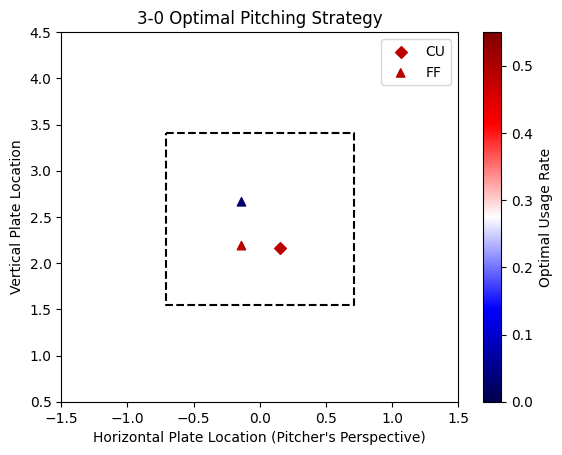

In [ ]:
#plot the 3-0 strategy
strat = cb_pit_dict['3-0']
pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': strat})
pitcher_df = pitcher_df.merge(pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]
ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']

plt.scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=plt.scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k--')
plt.xlabel("Horizontal Plate Location (Pitcher's Perspective)")
plt.ylabel('Vertical Plate Location')
plt.xlim(-1.5,1.5)
plt.ylim(0.5,4.5)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.title('3-0 Optimal Pitching Strategy')
plt.legend()
plt.show()

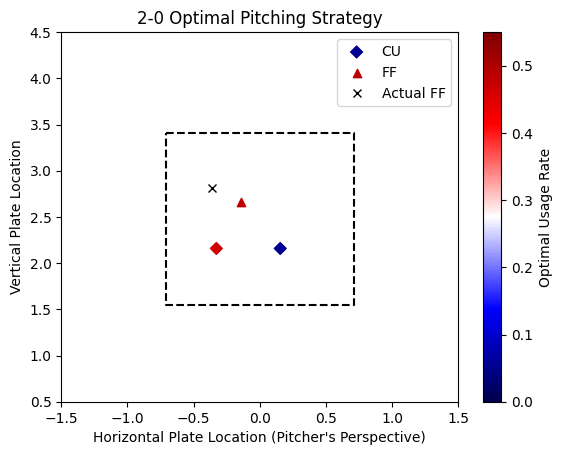

In [ ]:
#plot the 2-0 strategy
strat = cb_pit_dict['2-0']
pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': strat})
pitcher_df = pitcher_df.merge(pitch_grid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]
ff = d.loc[d.pitch_type == 'FF']
cu = d.loc[d.pitch_type == 'CU']

plt.scatter(-1*cu.plate_x_ft.values, cu.plate_z_ft.values, marker = 'D', label = 'CU', c = cu.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.55)
c=plt.scatter(-1*ff.plate_x_ft.values, ff.plate_z_ft.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.55)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k--')
#plot the actual pitch that Anderson threw
plt.plot([-.36], [2.81], 'kx', label = "Actual FF")
plt.xlabel("Horizontal Plate Location (Pitcher's Perspective)")
plt.ylabel('Vertical Plate Location')
plt.xlim(-1.5,1.5)
plt.ylim(0.5,4.5)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.title('2-0 Optimal Pitching Strategy')
plt.legend()
plt.show()

## Perfect Information Equilibrium
In the perfect info game, we assume the defense chooses the pitch specific positioning for the upcoming pitch, so the batter always knows what's coming. From the game theory perspective, that means that the pitcher has to choose the pitch that minimizes utility assuming that the batter will observe the full trajectory of the pitch and then make the optimal swing decision that maximizes utility.

In [ ]:
def get_exp_val(grid, tunnel_index, pitchtype):
    #filter to the right pitch type
    d = grid.loc[grid.pitch_type == pitchtype]
    #get mean and std dev
    mean = d.loc[d.tunnel_index == tunnel_index, ['plate_x_ft', 'plate_z_ft']].values[0]
    scale = d.command_skill.values[0]
    normal = mvnorm(mean, np.eye(2) * scale**2)

    #get likelihoods of all other pitches of the same type
    d['prob'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
    #normalize
    d['prob'] = d.prob/d.prob.sum()

    #now get weighted utility where the batter always chooses the better option
    weighted_util = d.prob * d.perfect_info_utility
    return np.sum(weighted_util).item()

In [ ]:
pi_val_dict= dict()
pi_pit_dict = dict()

#loop through the counts
for b in [0, 1, 2, 3]:
  for s in [0, 1, 2]:
    pitch_grid['balls'] = b
    pitch_grid['strikes'] = s
    x = torch.tensor(pitch_grid[['balls', 'strikes', 'release_speed_z', 'release_spin_rate_z', 'plate_x_z', 'plate_z_z', 'mx_z', 'mz_z', 'pit_handR', 'bat_handR', 'batter_index']].values, dtype = torch.float).to(device)
    preds = nn.functional.softmax(model(x), dim = -1)
    pitch_grid[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()
    pitch_grid['xbip'] = pitch_grid[['o4', 'o5', 'o6', 'o7', 'o8']].sum(axis = 1)

    #get the run values given the curveball positioning
    cb_pitch_grid = pitch_grid.merge(cb_outs, on = ['tunnel_index', 'pitch_type'])
    cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = cb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * cb_pitch_grid.xbip.values.reshape((-1,1))
    cb_pitch_grid = get_utility(cb_pitch_grid, cb_pitch_grid.balls.values[0], cb_pitch_grid.strikes.values[0])
    #remove non curveballs
    cb_pitch_grid = cb_pitch_grid.loc[cb_pitch_grid.pitch_type == 'CU']
    #get the expected utility of a curveball aimed in each tunnel, assuming the batter responds optimally
    cb_pitch_grid['utility'] = [get_exp_val(cb_pitch_grid, i, 'CU') for i in range(cb_pitch_grid.tunnel_index.max() + 1)]


    #get the run values given the fastball positioning
    fb_pitch_grid = pitch_grid.merge(fb_outs, on = ['tunnel_index', 'pitch_type'])
    fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']] = fb_pitch_grid[['xout', 'x1b', 'x2b', 'x3b', 'xhr']].values * fb_pitch_grid.xbip.values.reshape((-1,1))
    fb_pitch_grid = get_utility(fb_pitch_grid, fb_pitch_grid.balls.values[0], fb_pitch_grid.strikes.values[0])
    #remove non fastballs
    fb_pitch_grid = fb_pitch_grid.loc[fb_pitch_grid.pitch_type == 'FF']
    #get the expected utility of a curveball aimed in each tunnel, assuming the batter responds optimally
    fb_pitch_grid['utility'] = [get_exp_val(fb_pitch_grid, i, 'FF') for i in range(fb_pitch_grid.tunnel_index.max() + 1)]

    #what is the best choice of pitch ?
    opt_fb_ind = np.argmin(fb_pitch_grid.utility.values)
    opt_fb_tunnel = fb_pitch_grid.tunnel_index.values[opt_fb_ind]
    opt_fb_util = np.min(fb_pitch_grid.utility.values).item()

    opt_cb_ind = np.argmin(cb_pitch_grid.utility.values)
    opt_cb_tunnel = cb_pitch_grid.tunnel_index.values[opt_cb_ind]
    opt_cb_util = np.min(cb_pitch_grid.utility.values).item()

    if opt_cb_util < opt_fb_util:
      pi_val_dict[str(b) + '-' + str(s)] = opt_cb_util
      pi_pit_dict[str(b) + '-' + str(s)] = (opt_cb_tunnel, 'CU')
    else:
      pi_val_dict[str(b) + '-' + str(s)] = opt_fb_util
      pi_pit_dict[str(b) + '-' + str(s)] = (opt_fb_tunnel, 'FF')

In [ ]:
pi_val_dict

{'0-0': 0.01615992790422517,
 '0-1': 0.012702545051770327,
 '0-2': 0.01906640229949681,
 '1-0': 0.017142162615775326,
 '1-1': 0.018523034896007373,
 '1-2': 0.03304644661671418,
 '2-0': 0.015349487753342637,
 '2-1': 0.026064518768253726,
 '2-2': 0.04465688603003838,
 '3-0': -0.0005241449534870704,
 '3-1': 0.03574601122754216,
 '3-2': 0.06414044198856779}

In [ ]:
pi_pit_dict

{'0-0': (np.int64(229), 'FF'),
 '0-1': (np.int64(229), 'FF'),
 '0-2': (np.int64(250), 'FF'),
 '1-0': (np.int64(209), 'FF'),
 '1-1': (np.int64(209), 'FF'),
 '1-2': (np.int64(230), 'FF'),
 '2-0': (np.int64(209), 'FF'),
 '2-1': (np.int64(209), 'FF'),
 '2-2': (np.int64(209), 'FF'),
 '3-0': (np.int64(189), 'FF'),
 '3-1': (np.int64(228), 'CU'),
 '3-2': (np.int64(209), 'FF')}